# Road Damage Segmentation Training (FastSCNN, UNet, Mask R-CNN, DeepLab)

This notebook trains various segmentation models on the Road Damage Detection dataset (COCO format).
Models covered:
- FastSCNN (implemented in `src/fast_scnn.py`)
- UNet (from `segmentation-models-pytorch`)
- DeepLabV3+ (from `segmentation-models-pytorch`)
- Mask R-CNN (from `torchvision`)

**Prerequisites**:
Ensure `src/dataset.py` and `src/fast_scnn.py` exist and variables point to the correct data path.


In [1]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp

# Add parent directory to path to import src
sys.path.append(os.path.abspath('..'))

from src.dataset import RoadDamageDataset
from src.fast_scnn import FastSCNN

# Global Config
DATA_ROOT = '../data/road-damage-detection-coco'
BATCH_SIZE = 4
LR = 0.001
EPOCHS = 50
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# DEVICE = 'mps' if torch.backends.mps.is_available() else 'mps'

print(f"Using device: {DEVICE}")


/Users/dikaizm/Documents/PROGRAMMING/ml-ai/transtrack-safeway/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Train size: 1620
Valid size: 122
Classes: ['road_damage', 'crack', 'pothole']


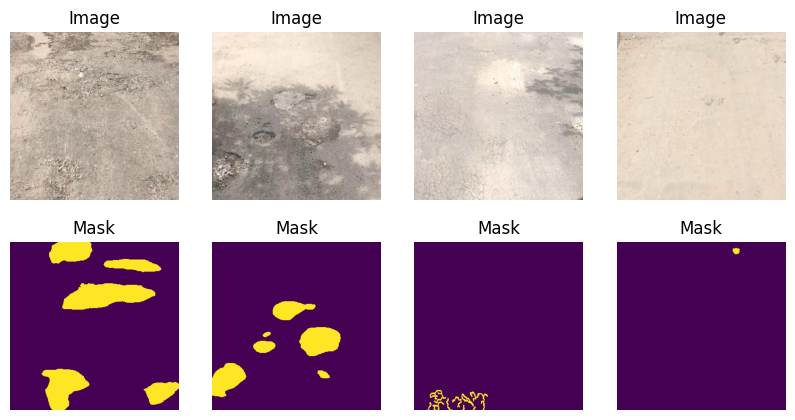

In [2]:
# Define Transformations
train_transform = A.Compose([
    A.Resize(320, 320),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(320, 320),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

# Create Datasets (Semantic Mode)
train_dataset = RoadDamageDataset(DATA_ROOT, split='train', mode='semantic', transform=train_transform)
valid_dataset = RoadDamageDataset(DATA_ROOT, split='valid', mode='semantic', transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Train size: {len(train_dataset)}")
print(f"Valid size: {len(valid_dataset)}")
print(f"Classes: {train_dataset.cat_names}")

# Visualization Function
def visualize_batch(loader):
    images, masks = next(iter(loader))
    plt.figure(figsize=(10, 5))
    for i in range(min(BATCH_SIZE, 4)):
        plt.subplot(2, 4, i+1)
        img = images[i].permute(1, 2, 0).numpy()
        # Un-normalize
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title("Image")
        plt.axis('off')
        
        plt.subplot(2, 4, i+5)
        plt.imshow(masks[i].numpy())
        plt.title("Mask")
        plt.axis('off')
    plt.show()

# Visualize a batch
visualize_batch(train_loader)

In [9]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, epochs=10):
    best_iou = 0.0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        
        for images, masks in train_loader:
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(images)
            if isinstance(outputs, tuple): # For models that return aux outputs
                outputs = outputs[0]
                
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.4f}")
        
        # Validation
        model.eval()
        valid_loss = 0
        intersection = 0
        union = 0
        
        with torch.no_grad():
            for images, masks in valid_loader:
                images = images.to(DEVICE)
                masks = masks.to(DEVICE)
                
                outputs = model(images)
                if isinstance(outputs, tuple):
                    outputs = outputs[0]
                
                loss = criterion(outputs, masks)
                valid_loss += loss.item()
                
                # IOU Calculation
                preds = torch.argmax(outputs, dim=1)
                intersection += (preds & masks).float().sum().item()
                union += (preds | masks).float().sum().item()
                
        iou = intersection / (union + 1e-6)
        print(f"Valid Loss: {valid_loss/len(valid_loader):.4f}, IOU: {iou:.4f}")
        
        if iou > best_iou:
            best_iou = iou
            torch.save(model.state_dict(), f"best_{model.__class__.__name__}.pth")
            print("Saved Best Model!")


In [10]:
# 1. Train FastSCNN
print("--- Training FastSCNN ---")
NUM_CLASSES = len(train_dataset.cat_names) + 1 # +1 for background 0

fast_scnn = FastSCNN(num_classes=NUM_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(fast_scnn.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss()

train_model(fast_scnn, train_loader, valid_loader, criterion, optimizer, epochs=EPOCHS)


--- Training FastSCNN ---
Epoch 1/10, Train Loss: 0.2799
Valid Loss: 0.2710, IOU: 0.1103
Saved Best Model!
Epoch 2/10, Train Loss: 0.2247
Valid Loss: 0.2540, IOU: 0.0000
Epoch 3/10, Train Loss: 0.2156
Valid Loss: 0.2509, IOU: 0.0050
Epoch 4/10, Train Loss: 0.2085
Valid Loss: 0.2469, IOU: 0.1082
Epoch 5/10, Train Loss: 0.2061
Valid Loss: 0.2864, IOU: 0.1452
Saved Best Model!
Epoch 6/10, Train Loss: 0.2054
Valid Loss: 0.2242, IOU: 0.1438
Epoch 7/10, Train Loss: 0.2020
Valid Loss: 0.2426, IOU: 0.1099
Epoch 8/10, Train Loss: 0.1992
Valid Loss: 0.2271, IOU: 0.0992
Epoch 9/10, Train Loss: 0.1898
Valid Loss: 0.2286, IOU: 0.2437
Saved Best Model!
Epoch 10/10, Train Loss: 0.1918
Valid Loss: 0.2317, IOU: 0.0963


In [ ]:
# 2. Train UNet (with ResNet34 backbone)
print("--- Training UNet ---")
unet = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=NUM_CLASSES,            # model output channels (number of classes in your dataset)
).to(DEVICE)

optimizer = torch.optim.Adam(unet.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss()

train_model(unet, train_loader, valid_loader, criterion, optimizer, epochs=EPOCHS)


--- Training UNet ---
Epoch 1/10, Train Loss: 0.2817
Valid Loss: 0.2794, IOU: 0.0000
Epoch 2/10, Train Loss: 0.2336
Valid Loss: 0.2572, IOU: 0.0000
Epoch 3/10, Train Loss: 0.2260
Valid Loss: 0.2759, IOU: 0.0000
Saved Best Model!
Epoch 4/10, Train Loss: 0.2235
Valid Loss: 0.3389, IOU: 0.0912
Saved Best Model!
Epoch 5/10, Train Loss: 0.2189
Valid Loss: 0.2824, IOU: 0.1553
Saved Best Model!
Epoch 6/10, Train Loss: 0.2123
Valid Loss: 0.2476, IOU: 0.1094
Epoch 7/10, Train Loss: 0.2049
Valid Loss: 0.2566, IOU: 0.0000
Epoch 8/10, Train Loss: 0.2034
Valid Loss: 0.2447, IOU: 0.1328


In [ ]:
# 3. Train DeepLabV3+
print("--- Training DeepLabV3+ ---")
deeplab = smp.DeepLabV3Plus(
    encoder_name="resnet34", 
    encoder_weights="imagenet", 
    in_channels=3, 
    classes=NUM_CLASSES
).to(DEVICE)

optimizer = torch.optim.Adam(deeplab.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss()

train_model(deeplab, train_loader, valid_loader, criterion, optimizer, epochs=EPOCHS)


In [ ]:
# 4. Train Mask R-CNN
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)
    return model

def collate_fn(batch):
    return tuple(zip(*batch))

# Create Instance Segmentation Datasets
# Note: transforms for Mask R-CNN need to handle bboxes/masks correctly. 
# Here we use basic storage without extensive augs for simplicity in this demo.
train_dataset_inst = RoadDamageDataset(DATA_ROOT, split='train', mode='instance')
valid_dataset_inst = RoadDamageDataset(DATA_ROOT, split='valid', mode='instance')

train_loader_inst = DataLoader(train_dataset_inst, batch_size=2, shuffle=True, num_workers=0, collate_fn=collate_fn)
valid_loader_inst = DataLoader(valid_dataset_inst, batch_size=2, shuffle=False, num_workers=0, collate_fn=collate_fn)

mask_rcnn = get_model_instance_segmentation(NUM_CLASSES).to(DEVICE)
params = [p for p in mask_rcnn.parameters() if p.requires_grad]
optimizer_inst = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_inst, step_size=3, gamma=0.1)

print("--- Training Mask R-CNN ---")

for epoch in range(EPOCHS):
    mask_rcnn.train()
    i = 0
    for images, targets in train_loader_inst:
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        loss_dict = mask_rcnn(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer_inst.zero_grad()
        losses.backward()
        optimizer_inst.step()

        if i % 10 == 0:
            print(f"Epoch {epoch}, Iter {i}, Loss: {losses.item():.4f}")
        i += 1
        
    lr_scheduler.step()
    
    # Save model
    torch.save(mask_rcnn.state_dict(), "best_MaskRCNN.pth")


In [ ]:
# 5. Prediction Visualization (Semantic)
model = fast_scnn # or unet, deeplab
model.eval()

images, masks = next(iter(valid_loader))
images = images.to(DEVICE)
outputs = model(images)
if isinstance(outputs, tuple): outputs = outputs[0]
preds = torch.argmax(outputs, dim=1).cpu().numpy()

plt.figure(figsize=(10, 5))
for i in range(min(BATCH_SIZE, 4)):
    # Image
    plt.subplot(3, 4, i+1)
    img = images[i].cpu().permute(1, 2, 0).numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    plt.imshow(np.clip(img, 0, 1))
    plt.title("Image")
    plt.axis('off')
    
    # Ground Truth
    plt.subplot(3, 4, i+5)
    plt.imshow(masks[i].numpy())
    plt.title("GT")
    plt.axis('off')
    
    # Prediction
    plt.subplot(3, 4, i+9)
    plt.imshow(preds[i])
    plt.title("Pred")
    plt.axis('off')
plt.show()


Visualizing log from: ../models/FastSCNN-20260210-2006/training_log.csv


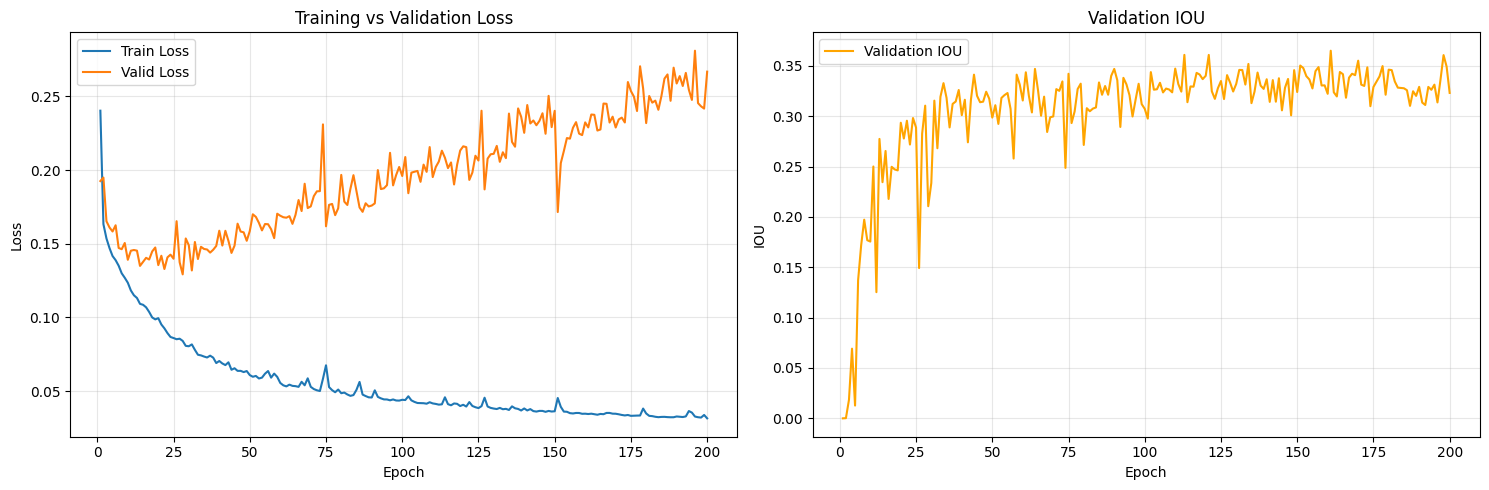

In [3]:
# 6. Training Visualization
import pandas as pd
import matplotlib.pyplot as plt
import os

# Find latest model folder (assumed structure: models/{ModelName}-{Timestamp})
# models_dir = '../models/BiSeNetV2-20260210-2010'
models_dir = '../models/FastSCNN-20260210-2006'
log_path = os.path.join(models_dir, 'training_log.csv')

print(f"Visualizing log from: {log_path}")

if os.path.exists(log_path):
    df = pd.read_csv(log_path)
    
    plt.figure(figsize=(15, 5))
    
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(df['epoch'], df['train_loss'], label='Train Loss')
    if 'valid_loss' in df.columns:
        plt.plot(df['epoch'], df['valid_loss'], label='Valid Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # IOU
    if 'iou' in df.columns:
        plt.subplot(1, 2, 2)
        plt.plot(df['epoch'], df['iou'], label='Validation IOU', color='orange')
        plt.title('Validation IOU')
        plt.xlabel('Epoch')
        plt.ylabel('IOU')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
    plt.tight_layout()
    plt.show()
else:
    print("Log file not found.")

In [ ]:
# 8. Evaluate on Test Images (Metrics)
import torch
import numpy as np
from torch.utils.data import DataLoader

# --- Evaluation Config ---
# Choose model to evaluate
EVAL_MODEL_ARCH = 'FastSCNN'   # Options: 'FastSCNN', 'UNet', 'DeepLabV3Plus', 'BiSeNetV2'
# Path to the specific model checkpoint you want to evaluate
EVAL_MODEL_PATH = '../models/FastSCNN-20260210-2006/best_model.pth' 
# -------------------------

print(f"Preparing evaluation for {EVAL_MODEL_ARCH}...")
print(f"Model Path: {EVAL_MODEL_PATH}")

# 1. Setup Test Data
# Note: Using 'val_transform' for test data (normalization/resizing without augmentation)
test_dataset = RoadDamageDataset(DATA_ROOT, split='test', mode='semantic', transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
num_eval_classes = len(test_dataset.cat_names) + 1  # +1 for Background

print(f"Test Dataset size: {len(test_dataset)} images")
print(f"Classes: {test_dataset.cat_names}")

# 2. Load Model Architecture
if EVAL_MODEL_ARCH == 'FastSCNN':
    from src.fast_scnn import FastSCNN
    model = FastSCNN(num_classes=num_eval_classes).to(DEVICE)
elif EVAL_MODEL_ARCH == 'BiSeNetV2':
    from src.bisenet_v2 import BiSeNetV2
    model = BiSeNetV2(num_classes=num_eval_classes).to(DEVICE)
elif EVAL_MODEL_ARCH == 'UNet':
    model = smp.Unet(encoder_name="resnet34", encoder_weights=None, in_channels=3, classes=num_eval_classes).to(DEVICE)
elif EVAL_MODEL_ARCH == 'DeepLabV3Plus':
    model = smp.DeepLabV3Plus(encoder_name="resnet34", encoder_weights=None, in_channels=3, classes=num_eval_classes).to(DEVICE)

# 3. Load Weights
try:
    model.load_state_dict(torch.load(EVAL_MODEL_PATH, map_location=DEVICE))
    model.eval()
    print("✓ Model loaded successfully.")
except FileNotFoundError:
    print(f"❌ Error: Model file not found at {EVAL_MODEL_PATH}")
    # We can't proceed without a model
    raise

# 4. Calculate Metrics (Pixel Accuracy & IoU)
total_correct_pixels = 0
total_pixels = 0
# Initialize intersection and union tensors for each class
intersection = torch.zeros(num_eval_classes).to(DEVICE)
union = torch.zeros(num_eval_classes).to(DEVICE)

print("\nRunning evaluation loop...")

with torch.no_grad():
    for i, (images, masks) in enumerate(test_loader):
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        
        # Forward pass
        outputs = model(images)
        if isinstance(outputs, tuple): 
            outputs = outputs[0]
            
        preds = torch.argmax(outputs, dim=1)
        
        # Pixel Accuracy Accumulation
        total_correct_pixels += (preds == masks).sum().item()
        total_pixels += masks.numel()
        
        # IoU Components Accumulation
        for cls in range(num_eval_classes):
            pred_cls = (preds == cls)
            target_cls = (masks == cls)
            
            # Intersection: True Positive
            inter = (pred_cls & target_cls).sum().float()
            # Union: TP + FP + FN
            uni = (pred_cls | target_cls).sum().float()
            
            intersection[cls] += inter
            union[cls] += uni
            
        if (i+1) % 10 == 0:
            print(f"Processed batch {i+1}/{len(test_loader)}...")

# 5. Compute Final Metrics
print("\n" + "="*40)
print(f"TEST EVALUATION RESULTS ({EVAL_MODEL_ARCH})")
print("="*40)

# Pixel Accuracy
pixel_acc = total_correct_pixels / total_pixels
print(f"Global Pixel Accuracy: {pixel_acc:.2%}")

# IoU per class and Mean IoU
iou_per_class = intersection / (union + 1e-6)
mean_iou = iou_per_class.mean().item()

print(f"Mean IoU (mIoU):       {mean_iou:.4f}")
print("-" * 40)
print(f"{'Class Name':<20} | {'IoU':<10}")
print("-" * 40)

# Class names incl Input Background
all_classes = ['Background'] + test_dataset.cat_names

for i, name in enumerate(all_classes):
    if i < len(iou_per_class):
        print(f"{name:<20} | {iou_per_class[i]:.4f}")

print("="*40)

Loading BiSeNetV2 from ../models/BiSeNetV2-20260210-2010/best_model.pth...
Model loaded successfully.
Testing on 3 random images from 59 available...
Processed image 1/3: IMG_1654_MOV-0049_jpg.rf.710da302fc41cd424511b316514eefc0.jpg
Processed image 2/3: IMG_1644_MOV-0017_jpg.rf.50e22df8838b4745e6bb3475169f1fac.jpg
Processed image 3/3: IMG_1654_MOV-0111_jpg.rf.b9c297aef5b5228fd30c710d73645bfe.jpg


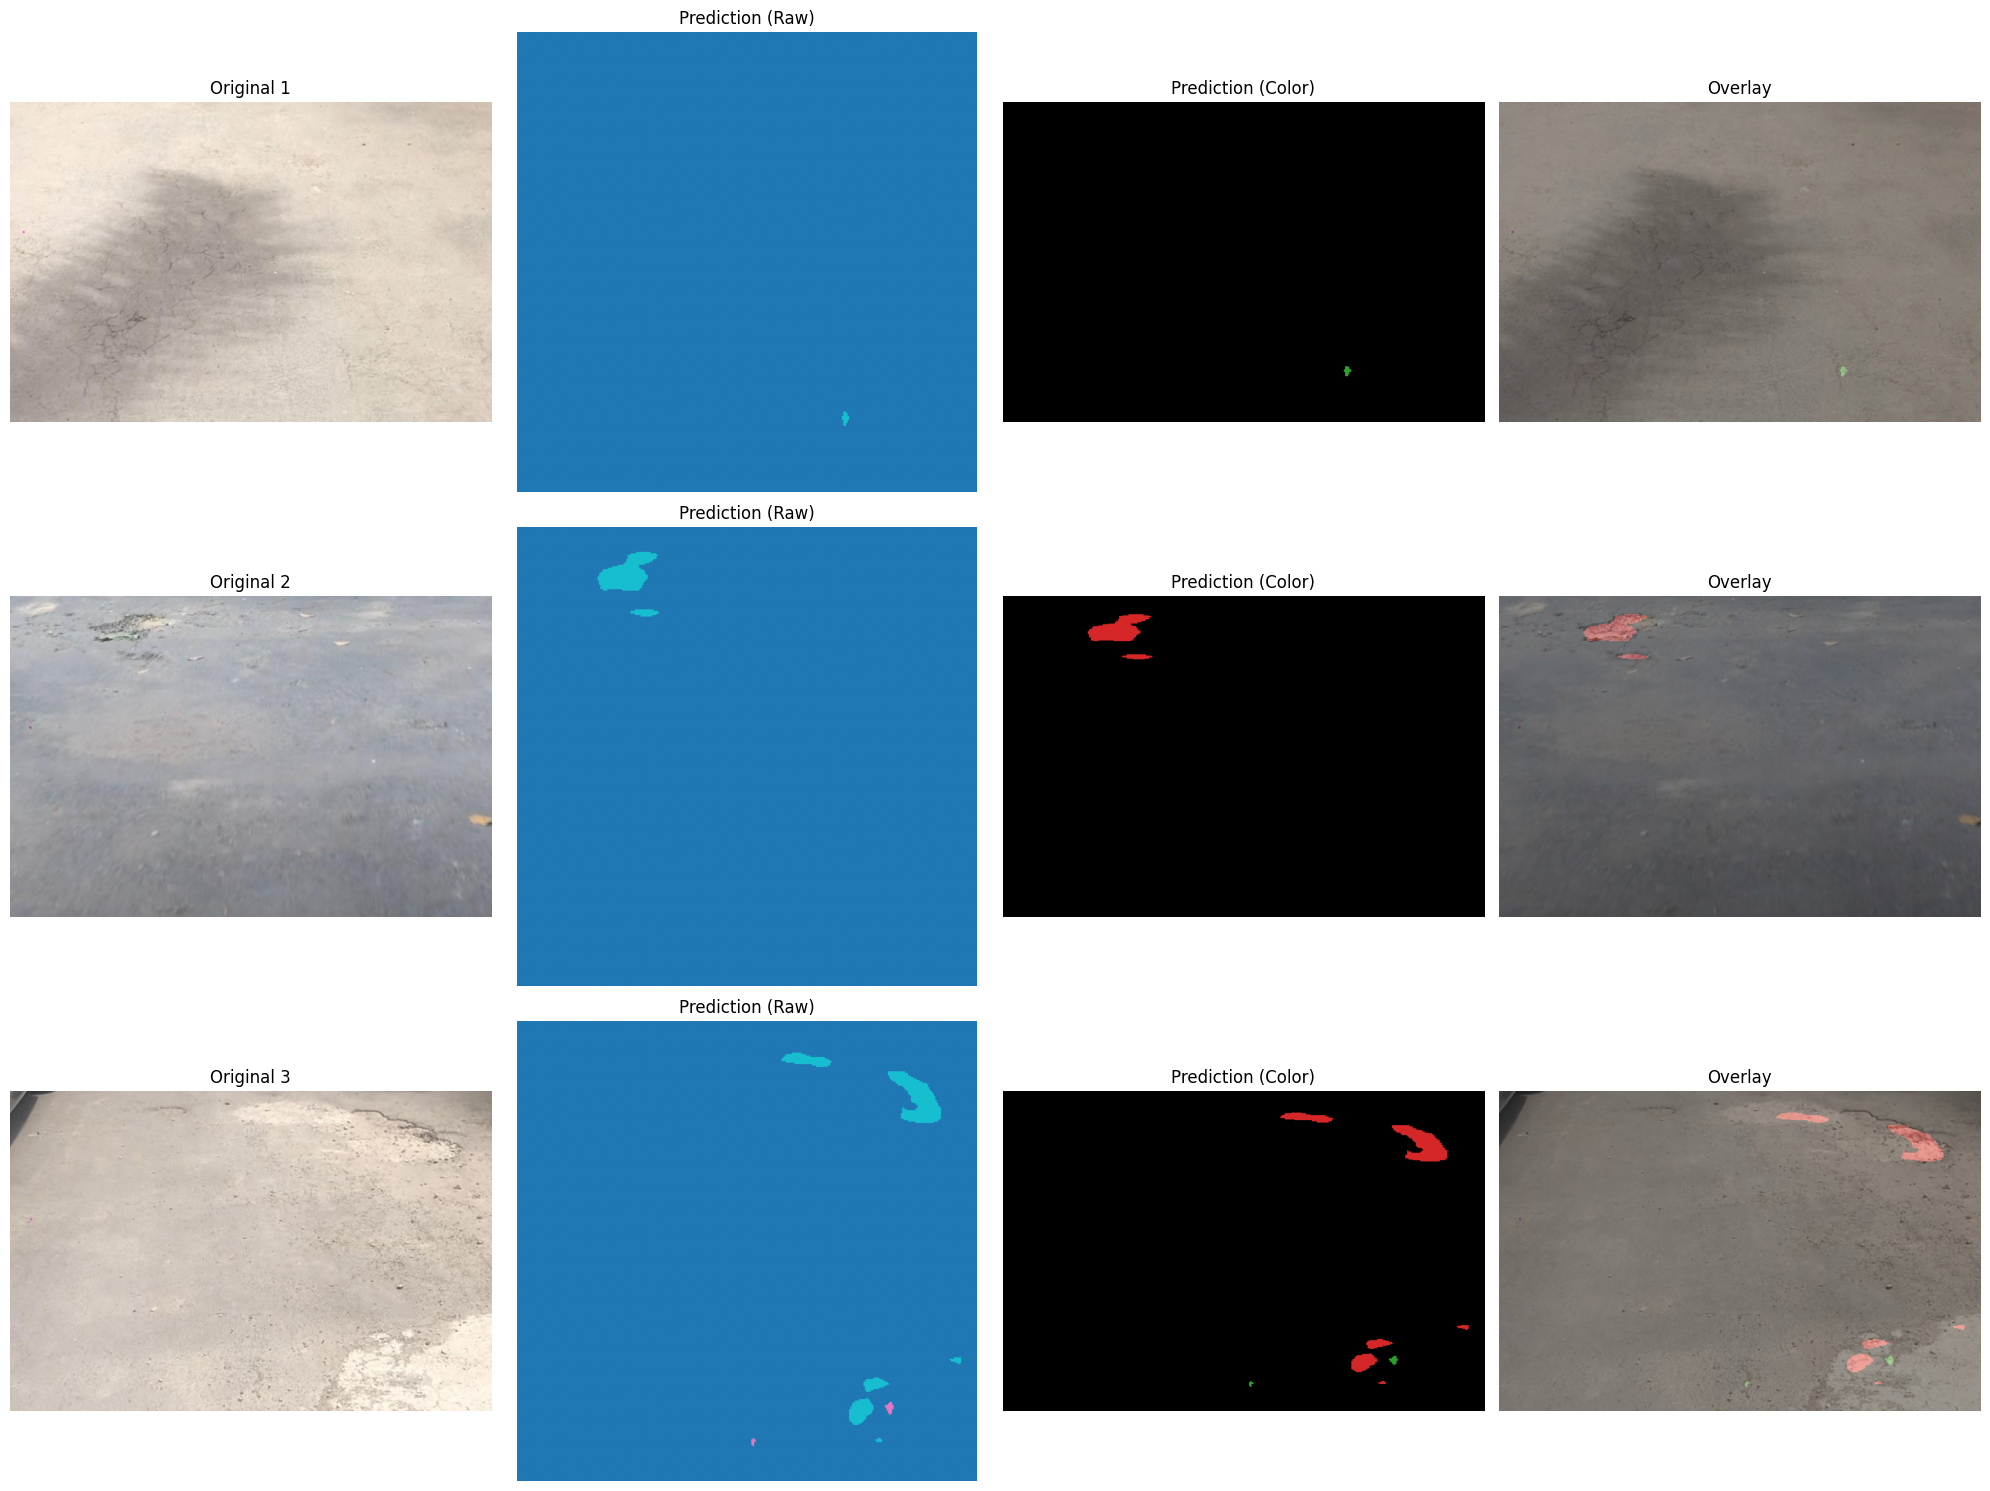


Test Summary:
- Total images tested: 3
- Model architecture: BiSeNetV2
- Number of classes: 4
- Class names: ['road_damage', 'crack', 'pothole']


In [8]:
# 7. Test on Random Test Images (10+ samples)
import random
import cv2

# --- Configuration ---
MODEL_ARCH = 'BiSeNetV2' # Options: 'FastSCNN', 'UNet', 'DeepLabV3Plus', 'BiSeNetV2'
# Automatically try to find best model in latest subdir, else specify path manually
MODEL_PATH = "../models/BiSeNetV2-20260210-2010/best_model.pth" 

print(f"Loading {MODEL_ARCH} from {MODEL_PATH}...")
# ---------------------

# 1. Load Model Architecture
num_classes = len(train_dataset.cat_names) + 1 # +1 Background

if MODEL_ARCH == 'FastSCNN':
    from src.fast_scnn import FastSCNN
    model = FastSCNN(num_classes=num_classes).to(DEVICE)
elif MODEL_ARCH == 'BiSeNetV2':
    from src.bisenet_v2 import BiSeNetV2
    model = BiSeNetV2(num_classes=num_classes).to(DEVICE)
elif MODEL_ARCH == 'UNet':
    model = smp.Unet(encoder_name="resnet34", encoder_weights=None, in_channels=3, classes=num_classes).to(DEVICE)
elif MODEL_ARCH == 'DeepLabV3Plus':
    model = smp.DeepLabV3Plus(encoder_name="resnet34", encoder_weights=None, in_channels=3, classes=num_classes).to(DEVICE)

# 2. Load Weights
try:
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.eval()
    print("Model loaded successfully.")
except FileNotFoundError:
    print(f"Error: Model file not found at {MODEL_PATH}")
    raise

# 3. Helpers
def colorize_mask(mask, num_classes):
    # Simple color map (using tab10 colormap)
    cmap = plt.get_cmap('tab10')
    H, W = mask.shape
    colored = np.zeros((H, W, 3), dtype=np.uint8)
    for i in range(1, num_classes): # Skip background 0
        color = np.array(cmap(i % 10)[:3]) * 255
        colored[mask == i] = color
    return colored

# 4. Find test images
test_dir = os.path.join(DATA_ROOT, 'test')
if not os.path.exists(test_dir): 
    test_dir = os.path.join(DATA_ROOT, 'valid') # Fallback
test_images = [os.path.join(test_dir, f) for f in os.listdir(test_dir) if f.endswith(('.jpg', '.png'))]

# 5. Test on 10+ random images
NUM_TEST_IMAGES = min(3, len(test_images))  # Test on 12 images (or fewer if not available)

if test_images:
    print(f"Testing on {NUM_TEST_IMAGES} random images from {len(test_images)} available...")
    random_images = random.sample(test_images, NUM_TEST_IMAGES)
    
    # Create figure with subplots
    fig, axes = plt.subplots(NUM_TEST_IMAGES, 4, figsize=(20, 5 * NUM_TEST_IMAGES))
    
    for idx, img_path in enumerate(random_images):
        # Load and preprocess image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        original_h, original_w = image.shape[:2]
        
        # Preprocess (Resize to 320x320 for model input)
        input_img = val_transform(image=image)["image"]
        input_tensor = input_img.unsqueeze(0).to(DEVICE)
        
        # Inference
        with torch.no_grad():
            output = model(input_tensor)
            if isinstance(output, tuple): 
                output = output[0]
            probs = torch.softmax(output, dim=1)
            pred_mask = torch.argmax(probs, dim=1).squeeze().cpu().numpy()
        
        # Visualization
        colored_mask = colorize_mask(pred_mask, num_classes)
        # Resize mask back to original image size for overlay
        colored_mask_resized = cv2.resize(colored_mask, (original_w, original_h), interpolation=cv2.INTER_NEAREST)
        overlay = cv2.addWeighted(image, 0.6, colored_mask_resized, 0.4, 0)
        
        # Plot in grid
        ax_row = axes[idx] if NUM_TEST_IMAGES > 1 else axes
        ax_row[0].imshow(image)
        ax_row[0].set_title(f"Original {idx+1}")
        ax_row[0].axis('off')
        
        ax_row[1].imshow(pred_mask, cmap='tab10')
        ax_row[1].set_title(f"Prediction (Raw)")
        ax_row[1].axis('off')
        
        ax_row[2].imshow(colored_mask_resized)
        ax_row[2].set_title(f"Prediction (Color)")
        ax_row[2].axis('off')
        
        ax_row[3].imshow(overlay)
        ax_row[3].set_title(f"Overlay")
        ax_row[3].axis('off')
        
        print(f"Processed image {idx+1}/{NUM_TEST_IMAGES}: {os.path.basename(img_path)}")
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\nTest Summary:")
    print(f"- Total images tested: {NUM_TEST_IMAGES}")
    print(f"- Model architecture: {MODEL_ARCH}")
    print(f"- Number of classes: {num_classes}")
    print(f"- Class names: {train_dataset.cat_names}")
    
else:
    print("No images found for testing.")

Loading FastSCNN from ../models/FastSCNN-20260210-2006/best_model.pth...

DEVICE SPECIFICATIONS
Platform: macOS-15.3.2-arm64-arm-64bit
Processor: arm
CPU Cores: 14 physical, 14 logical
RAM: 24.00 GB

Current Device: CPU
PyTorch Version: 2.10.0
Device Used for Inference: cpu

✓ Model loaded successfully.

Model Parameters:
  Total: 1,234,004
  Trainable: 1,234,004
  Size: ~4.71 MB (FP32)

Found 59 test images in ../data/road-damage-detection-coco/test

Performing warm-up runs...
✓ Warm-up complete

INFERENCE SPEED BENCHMARK
Processed 50/59 images...
Processed 59/59 images...

TIMING STATISTICS (milliseconds)

Preprocessing:
  Mean:    2.82 ms
  Median:  2.75 ms
  Std Dev: 0.40 ms
  Min:     2.11 ms
  Max:     3.83 ms
  95th %:  3.45 ms

Inference (Model):
  Mean:    56.05 ms
  Median:  55.55 ms
  Std Dev: 3.01 ms
  Min:     49.52 ms
  Max:     64.93 ms
  95th %:  62.24 ms

Postprocessing:
  Mean:    17.29 ms
  Median:  17.19 ms
  Std Dev: 0.77 ms
  Min:     16.06 ms
  Max:     20.31 ms


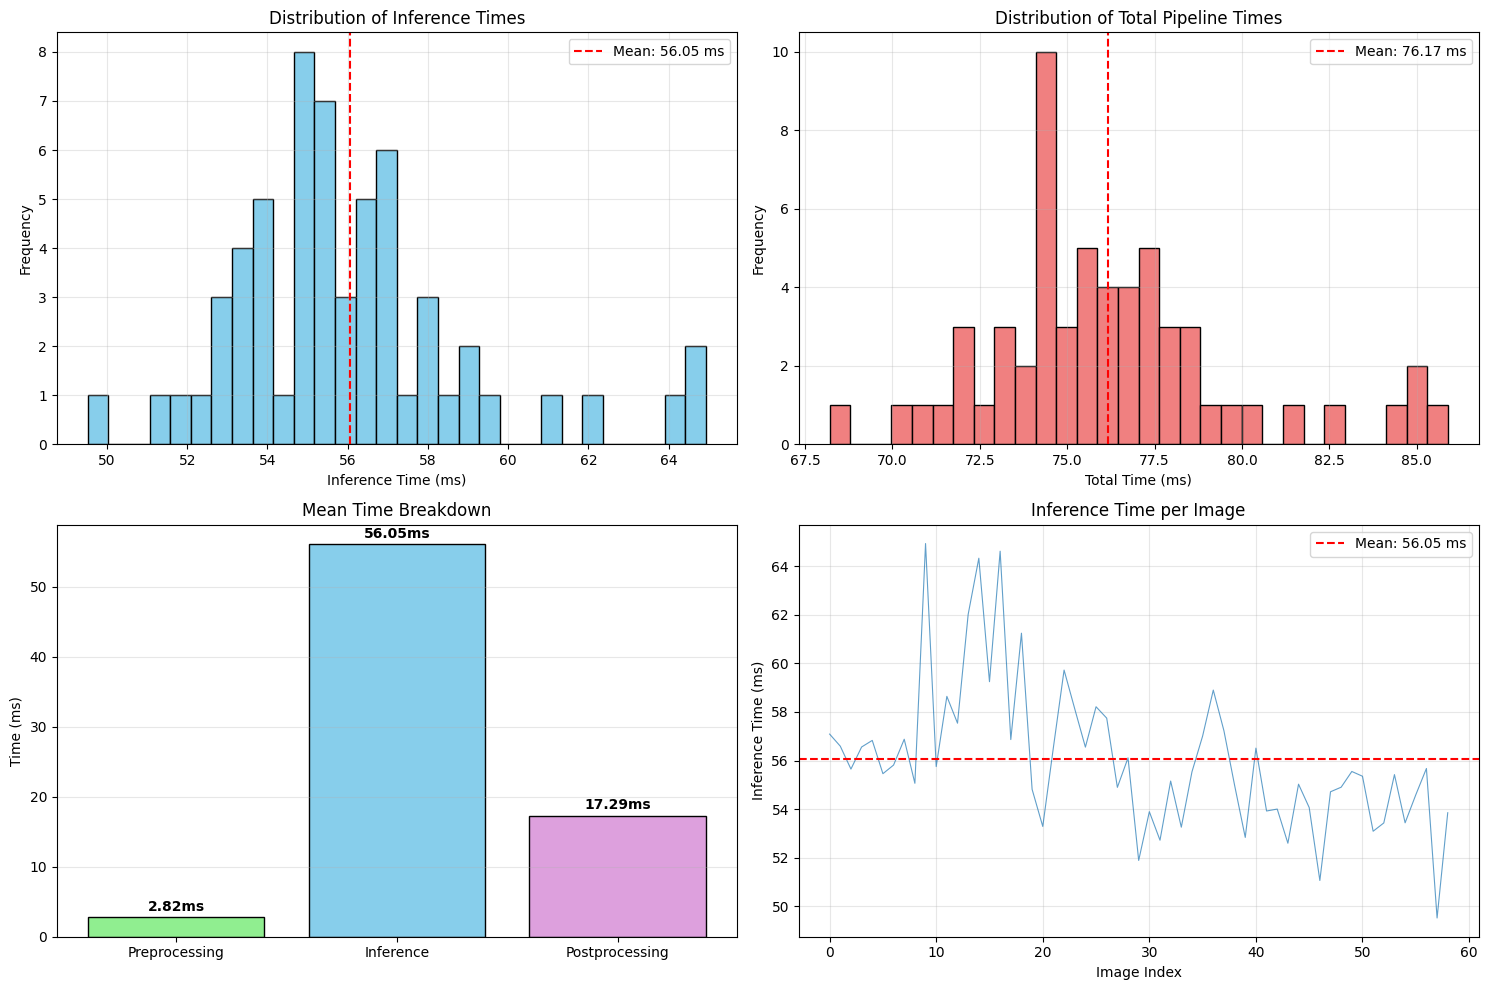


BENCHMARK COMPLETE


In [11]:
# Inference Speed Benchmark on Test Images
import random
import cv2
import time
import platform
import psutil

# --- Configuration ---
MODEL_ARCH = 'FastSCNN' # Options: 'FastSCNN', 'UNet', 'DeepLabV3Plus', 'BiSeNetV2'
MODEL_PATH = "../models/FastSCNN-20260210-2006/best_model.pth" 

print(f"Loading {MODEL_ARCH} from {MODEL_PATH}...")
# ---------------------

# 1. Display Device Specifications
print("\n" + "="*80)
print("DEVICE SPECIFICATIONS")
print("="*80)

# CPU Info
print(f"Platform: {platform.platform()}")
print(f"Processor: {platform.processor()}")
print(f"CPU Cores: {psutil.cpu_count(logical=False)} physical, {psutil.cpu_count(logical=True)} logical")
print(f"RAM: {psutil.virtual_memory().total / (1024**3):.2f} GB")

# GPU Info
if torch.cuda.is_available():
    print(f"\nGPU Device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / (1024**3):.2f} GB")
    print(f"Current Device: CUDA (GPU)")
else:
    print(f"\nCurrent Device: CPU")

print(f"PyTorch Version: {torch.__version__}")
print(f"Device Used for Inference: {DEVICE}")
print("="*80 + "\n")

# 2. Load Model Architecture
num_classes = len(train_dataset.cat_names) + 1 # +1 Background

if MODEL_ARCH == 'FastSCNN':
    from src.fast_scnn import FastSCNN
    model = FastSCNN(num_classes=num_classes).to(DEVICE)
elif MODEL_ARCH == 'BiSeNetV2':
    from src.bisenet_v2 import BiSeNetV2
    model = BiSeNetV2(num_classes=num_classes).to(DEVICE)
elif MODEL_ARCH == 'UNet':
    model = smp.Unet(encoder_name="resnet34", encoder_weights=None, in_channels=3, classes=num_classes).to(DEVICE)
elif MODEL_ARCH == 'DeepLabV3Plus':
    model = smp.DeepLabV3Plus(encoder_name="resnet34", encoder_weights=None, in_channels=3, classes=num_classes).to(DEVICE)

# 3. Load Weights
try:
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.eval()
    print("✓ Model loaded successfully.\n")
except FileNotFoundError:
    print(f"Error: Model file not found at {MODEL_PATH}")
    raise

# 4. Count Model Parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model Parameters:")
print(f"  Total: {total_params:,}")
print(f"  Trainable: {trainable_params:,}")
print(f"  Size: ~{total_params * 4 / (1024**2):.2f} MB (FP32)\n")

# 5. Find test images
test_dir = os.path.join(DATA_ROOT, 'test')
if not os.path.exists(test_dir): 
    test_dir = os.path.join(DATA_ROOT, 'valid')
test_images = [os.path.join(test_dir, f) for f in os.listdir(test_dir) if f.endswith(('.jpg', '.png'))]

if not test_images:
    print("No test images found!")
    raise FileNotFoundError("No test images available")

print(f"Found {len(test_images)} test images in {test_dir}\n")

# 6. Warm-up run (to initialize CUDA kernels if using GPU)
print("Performing warm-up runs...")
warmup_img = cv2.imread(test_images[0])
warmup_img = cv2.cvtColor(warmup_img, cv2.COLOR_BGR2RGB)
warmup_tensor = val_transform(image=warmup_img)["image"].unsqueeze(0).to(DEVICE)

for _ in range(5):
    with torch.no_grad():
        _ = model(warmup_tensor)
        
if torch.cuda.is_available():
    torch.cuda.synchronize()
print("✓ Warm-up complete\n")

# 7. Benchmark Inference Speed
print("="*80)
print("INFERENCE SPEED BENCHMARK")
print("="*80)

inference_times = []
preprocessing_times = []
postprocessing_times = []
total_times = []

for idx, img_path in enumerate(test_images):
    start_total = time.time()
    
    # Preprocessing
    start_preprocess = time.time()
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    input_img = val_transform(image=image)["image"]
    input_tensor = input_img.unsqueeze(0).to(DEVICE)
    end_preprocess = time.time()
    
    # Inference
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    
    start_inference = time.time()
    with torch.no_grad():
        output = model(input_tensor)
        if isinstance(output, tuple): 
            output = output[0]
    
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    end_inference = time.time()
    
    # Postprocessing
    start_postprocess = time.time()
    probs = torch.softmax(output, dim=1)
    pred_mask = torch.argmax(probs, dim=1).squeeze().cpu().numpy()
    end_postprocess = time.time()
    
    end_total = time.time()
    
    # Record times
    preprocess_time = (end_preprocess - start_preprocess) * 1000  # ms
    inference_time = (end_inference - start_inference) * 1000  # ms
    postprocess_time = (end_postprocess - start_postprocess) * 1000  # ms
    total_time = (end_total - start_total) * 1000  # ms
    
    preprocessing_times.append(preprocess_time)
    inference_times.append(inference_time)
    postprocessing_times.append(postprocess_time)
    total_times.append(total_time)
    
    if (idx + 1) % 50 == 0 or (idx + 1) == len(test_images):
        print(f"Processed {idx + 1}/{len(test_images)} images...")

# 8. Calculate Statistics
print("\n" + "="*80)
print("TIMING STATISTICS (milliseconds)")
print("="*80)

def print_stats(times, label):
    print(f"\n{label}:")
    print(f"  Mean:    {np.mean(times):.2f} ms")
    print(f"  Median:  {np.median(times):.2f} ms")
    print(f"  Std Dev: {np.std(times):.2f} ms")
    print(f"  Min:     {np.min(times):.2f} ms")
    print(f"  Max:     {np.max(times):.2f} ms")
    print(f"  95th %:  {np.percentile(times, 95):.2f} ms")

print_stats(preprocessing_times, "Preprocessing")
print_stats(inference_times, "Inference (Model)")
print_stats(postprocessing_times, "Postprocessing")
print_stats(total_times, "Total Pipeline")

# 9. FPS Calculation
mean_inference_time = np.mean(inference_times)
mean_total_time = np.mean(total_times)

fps_inference_only = 1000 / mean_inference_time
fps_total = 1000 / mean_total_time

print("\n" + "="*80)
print("THROUGHPUT")
print("="*80)
print(f"FPS (Inference only): {fps_inference_only:.2f}")
print(f"FPS (Total pipeline): {fps_total:.2f}")
print(f"\nTotal images processed: {len(test_images)}")
print(f"Total time: {sum(total_times)/1000:.2f} seconds")

# 10. Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histogram of inference times
axes[0, 0].hist(inference_times, bins=30, color='skyblue', edgecolor='black')
axes[0, 0].axvline(np.mean(inference_times), color='red', linestyle='--', label=f'Mean: {np.mean(inference_times):.2f} ms')
axes[0, 0].set_xlabel('Inference Time (ms)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Inference Times')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Histogram of total times
axes[0, 1].hist(total_times, bins=30, color='lightcoral', edgecolor='black')
axes[0, 1].axvline(np.mean(total_times), color='red', linestyle='--', label=f'Mean: {np.mean(total_times):.2f} ms')
axes[0, 1].set_xlabel('Total Time (ms)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Total Pipeline Times')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Time breakdown
time_components = ['Preprocessing', 'Inference', 'Postprocessing']
mean_times = [np.mean(preprocessing_times), np.mean(inference_times), np.mean(postprocessing_times)]
colors = ['lightgreen', 'skyblue', 'plum']

axes[1, 0].bar(time_components, mean_times, color=colors, edgecolor='black')
axes[1, 0].set_ylabel('Time (ms)')
axes[1, 0].set_title('Mean Time Breakdown')
axes[1, 0].grid(axis='y', alpha=0.3)

for i, v in enumerate(mean_times):
    axes[1, 0].text(i, v + 0.5, f'{v:.2f}ms', ha='center', va='bottom', fontweight='bold')

# Inference time over images (to check for patterns)
axes[1, 1].plot(inference_times, alpha=0.7, linewidth=0.8)
axes[1, 1].axhline(np.mean(inference_times), color='red', linestyle='--', label=f'Mean: {np.mean(inference_times):.2f} ms')
axes[1, 1].set_xlabel('Image Index')
axes[1, 1].set_ylabel('Inference Time (ms)')
axes[1, 1].set_title('Inference Time per Image')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("BENCHMARK COMPLETE")
print("="*80)

In [ ]:
# 8. Real-time Video Inference
# Note: cv2.imshow window might not appear in all remote storage environments.
import cv2
import time

# --- Config ---
VIDEO_SOURCE = 0 # Use 0 for webcam, or path to video file (e.g. '../video.mp4')
# --------------

def run_video_inference():
    cap = cv2.VideoCapture(VIDEO_SOURCE)

    if not cap.isOpened():
        print(f"Error opening video source {VIDEO_SOURCE}")
        return

    print("Starting video inference... Press 'q' to quit.")
    
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
                
            start_time = time.time()
            
            # Preprocess
            # Resize frame to 320x320 for the model
            input_frame = cv2.resize(frame, (320, 320))
            input_frame = cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB)
            
            # Normalize (Manual matching albumentations)
            img_tensor = input_frame.astype(np.float32) / 255.0
            img_tensor = (img_tensor - np.array([0.485, 0.456, 0.406])) / np.array([0.229, 0.224, 0.225])
            img_tensor = torch.from_numpy(img_tensor.transpose(2, 0, 1)).float().unsqueeze(0).to(DEVICE)
            
            # Inference
            with torch.no_grad():
                output = model(img_tensor)
                if isinstance(output, tuple): output = output[0]
                pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()
            
            # Colorize
            colored_pred = colorize_mask(pred, num_classes)
            # Convert back to BGR for OpenCV
            colored_pred_bgr = cv2.cvtColor(colored_pred, cv2.COLOR_RGB2BGR)
            
            # Resize prediction back to original frame size
            colored_pred_resized = cv2.resize(colored_pred_bgr, (frame.shape[1], frame.shape[0]), interpolation=cv2.INTER_NEAREST)
            
            # Overlay
            overlay = cv2.addWeighted(frame, 0.7, colored_pred_resized, 0.3, 0)
            
            # FPS
            fps = 1.0 / (time.time() - start_time)
            cv2.putText(overlay, f"FPS: {fps:.1f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            
            cv2.imshow('Road Damage Detection', overlay)
            
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    except KeyboardInterrupt:
        print("Interrupted by user")
    finally:
        cap.release()
        cv2.destroyAllWindows()

# Uncomment to run
# run_video_inference()
